## Prepare the workspace

In [ ]:
!pip install torch==1.9.1
!pip install twine==3.8.0

In [ ]:
## Restart after installtion

In [1]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled. 

2.0.1
True


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [2]:
# Imports here
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). 

If you do not find the `flowers/` dataset in the current directory, **/workspace/home/aipnd-project/**, you can download it using the following commands. 

**Method 1**
```bash
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers
```


**Method 2**
```bash
!cp -r /data/ .
```

## Data Description
The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
validation_data = datasets.ImageFolder(test_dir, transform=validation_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True,num_workers=3)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True,num_workers=3)
validationloader  = torch.utils.data.DataLoader(validation_data, batch_size=16, shuffle=True,num_workers=3)


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. 

## Note for Workspace users: 
If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [6]:
# TODO: Build and train your network
from collections import OrderedDict
network_struct = {"densenet121" : 1024,
                 "alexnet" : 9216,
                 "vgg16":25088}

def network_setup(nstruct='densenet121',dropout=0.5, hidden_layer1 = 120,lr = 0.001):
    print("Getting the model")
    if(nstruct=="densenet121"):
        model = models.densenet121(pretrained=True)
    elif(nstruct=="alexnet"):
        model = models.alexnet(pretrained=True)
    elif(nstruct=="vgg16"):
        model = models.vgg16(pretrained=True)
    else :
        print("The network stucure type {} yoy chose is unavailale type,  allowed are :densenet121, alexet, vgg16.".format(network_struct))
    
    print("freezing the layers")    
    for param in model.parameters():
        param.requires_grad = False

    print("Defining the classifier")
    classifier = nn.Sequential(OrderedDict([
        ('dropout',nn.Dropout(dropout)),
        ('inputs', nn.Linear(network_struct[nstruct], hidden_layer1)),
        ('relu1', nn.ReLU()),
        ('hidden_layer1', nn.Linear(hidden_layer1, 256)),
        ('relu2',nn.ReLU()),
        ('hidden_layer3',nn.Linear(256,102)),
        ('output', nn.LogSoftmax(dim=1))
                      ]))
        
    print("Optimers")    
    model.classifier = classifier
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr )
    print("Returing the model")    
    return model , optimizer ,criterion 

    
dropout=0.5
hidden_layer1 = 120
lr = 0.001
nstruct='densenet121'

model,optimizer,criterion = network_setup (nstruct,dropout, hidden_layer1,lr)

Getting the model


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


freezing the layers
Defining the classifier
Optimers
Returing the model


In [7]:
# Defining validation 
def validation(model, valid_loader, criterion,device):
    model.to(device)
    valid_loss = 0
    accuracy = 0
    for inputs, labels in valid_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)
        output = model.forward(inputs)
        valid_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return valid_loss, accuracy

In [8]:
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20
print_every = 50
steps = 0
loss_show=[]
model.to(device)
print("Start Training")

start_train = time.time()

for e in range(epochs):
    model.train()
    running_loss = 0
    start = time.time()
    for il, (inputs, labels) in enumerate(trainloader):
        steps += 1
        print (steps)
        print (round((time.time()-start)/60,2)," minutes")
        
        inputs,labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if steps % print_every == 0:
            model.eval () 
            with torch.no_grad():
                validationlost, accuracy = validation(model, validationloader, criterion,device)
                    
            validationlost = validationlost / len(validationloader)
            accuracy = accuracy /len(validationloader)
            
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every),
                  "Validation Lost {:.4f}".format(validationlost),
                  "Accuracy: {:.4f}".format(accuracy))
            
            
            running_loss = 0
            model.train()
    end = time.time()
    print("Time taken for Epoch: ", e," is ",round((end-start)/60,2)," minutes")
    
print("Model Trained")
print ("Total time for train:" ,round((time.time()-start_train)/60,2)," minutes")


Start Training
1
0.07  minutes
2
0.13  minutes
3
0.13  minutes
4
0.14  minutes
5
0.14  minutes
6
0.15  minutes
7
0.15  minutes
8
0.16  minutes
9
0.17  minutes
10
0.17  minutes
11
0.19  minutes
12
0.2  minutes
13
0.21  minutes
14
0.22  minutes
15
0.24  minutes
16
0.24  minutes
17
0.26  minutes
18
0.27  minutes
19
0.28  minutes
20
0.29  minutes
21
0.3  minutes
22
0.31  minutes
23
0.33  minutes
24
0.34  minutes
25
0.34  minutes
26
0.36  minutes
27
0.37  minutes
28
0.38  minutes
29
0.39  minutes
30
0.41  minutes
31
0.41  minutes
32
0.43  minutes
33
0.44  minutes
34
0.45  minutes
35
0.46  minutes
36
0.48  minutes
37
0.48  minutes
38
0.49  minutes
39
0.51  minutes
40
0.51  minutes
41
0.53  minutes
42
0.54  minutes
43
0.55  minutes
44
0.56  minutes
45
0.58  minutes
46
0.58  minutes
47
0.59  minutes
48
0.61  minutes
49
0.61  minutes
50
0.63  minutes
Epoch: 1/20...  Loss: 4.4129 Validation Lost 3.9882 Accuracy: 0.1490
51
0.89  minutes
52
0.9  minutes
53
0.9  minutes
54
0.91  minutes
55
0.91  mi

424
0.18  minutes
425
0.2  minutes
426
0.21  minutes
427
0.22  minutes
428
0.24  minutes
429
0.26  minutes
430
0.26  minutes
431
0.27  minutes
432
0.3  minutes
433
0.3  minutes
434
0.31  minutes
435
0.33  minutes
436
0.34  minutes
437
0.34  minutes
438
0.37  minutes
439
0.38  minutes
440
0.38  minutes
441
0.41  minutes
442
0.41  minutes
443
0.42  minutes
444
0.45  minutes
445
0.45  minutes
446
0.46  minutes
447
0.48  minutes
448
0.49  minutes
449
0.49  minutes
450
0.52  minutes
Epoch: 5/20...  Loss: 1.0937 Validation Lost 0.7476 Accuracy: 0.7945
451
0.76  minutes
452
0.76  minutes
453
0.76  minutes
454
0.77  minutes
455
0.77  minutes
456
0.78  minutes
457
0.79  minutes
458
0.8  minutes
459
0.8  minutes
460
0.82  minutes
461
0.83  minutes
462
0.84  minutes
463
0.86  minutes
464
0.86  minutes
465
0.87  minutes
466
0.89  minutes
467
0.9  minutes
468
0.9  minutes
469
0.93  minutes
470
0.93  minutes
471
0.94  minutes
472
0.96  minutes
473
0.97  minutes
474
0.97  minutes
475
0.99  minutes
47

842
0.26  minutes
843
0.27  minutes
844
0.3  minutes
845
0.3  minutes
846
0.31  minutes
847
0.34  minutes
848
0.34  minutes
849
0.35  minutes
850
0.37  minutes
Epoch: 9/20...  Loss: 0.6588 Validation Lost 0.4806 Accuracy: 0.8734
851
0.61  minutes
852
0.62  minutes
853
0.62  minutes
854
0.63  minutes
855
0.63  minutes
856
0.64  minutes
857
0.65  minutes
858
0.66  minutes
859
0.67  minutes
860
0.68  minutes
861
0.7  minutes
862
0.71  minutes
863
0.72  minutes
864
0.74  minutes
865
0.75  minutes
866
0.76  minutes
867
0.78  minutes
868
0.79  minutes
869
0.81  minutes
870
0.82  minutes
871
0.83  minutes
872
0.85  minutes
873
0.86  minutes
874
0.87  minutes
875
0.9  minutes
876
0.9  minutes
877
0.91  minutes
878
0.94  minutes
879
0.94  minutes
880
0.95  minutes
881
0.97  minutes
882
0.98  minutes
883
0.98  minutes
884
1.01  minutes
885
1.01  minutes
886
1.02  minutes
887
1.04  minutes
888
1.05  minutes
889
1.05  minutes
890
1.08  minutes
891
1.08  minutes
892
1.09  minutes
893
1.11  minutes


1246
0.18  minutes
1247
0.18  minutes
1248
0.19  minutes
1249
0.21  minutes
1250
0.22  minutes
Epoch: 13/20...  Loss: 0.3213 Validation Lost 0.4464 Accuracy: 0.8762
1251
0.51  minutes
1252
0.51  minutes
1253
0.51  minutes
1254
0.52  minutes
1255
0.52  minutes
1256
0.53  minutes
1257
0.54  minutes
1258
0.55  minutes
1259
0.56  minutes
1260
0.58  minutes
1261
0.58  minutes
1262
0.59  minutes
1263
0.61  minutes
1264
0.62  minutes
1265
0.63  minutes
1266
0.65  minutes
1267
0.65  minutes
1268
0.66  minutes
1269
0.68  minutes
1270
0.69  minutes
1271
0.7  minutes
1272
0.72  minutes
1273
0.73  minutes
1274
0.73  minutes
1275
0.75  minutes
1276
0.76  minutes
1277
0.77  minutes
1278
0.79  minutes
1279
0.8  minutes
1280
0.81  minutes
1281
0.82  minutes
1282
0.83  minutes
1283
0.84  minutes
1284
0.86  minutes
1285
0.87  minutes
1286
0.88  minutes
1287
0.89  minutes
1288
0.9  minutes
1289
0.91  minutes
1290
0.93  minutes
1291
0.94  minutes
1292
0.95  minutes
1293
0.96  minutes
1294
0.97  minutes
12

1643
1.61  minutes
1644
1.62  minutes
1645
1.64  minutes
1646
1.65  minutes
1647
1.65  minutes
1648
1.66  minutes
Time taken for Epoch:  15  is  1.66  minutes
1649
0.06  minutes
1650
0.07  minutes
Epoch: 17/20...  Loss: 0.0428 Validation Lost 0.3950 Accuracy: 0.8906
1651
0.32  minutes
1652
0.33  minutes
1653
0.33  minutes
1654
0.34  minutes
1655
0.34  minutes
1656
0.35  minutes
1657
0.36  minutes
1658
0.37  minutes
1659
0.37  minutes
1660
0.39  minutes
1661
0.4  minutes
1662
0.41  minutes
1663
0.43  minutes
1664
0.44  minutes
1665
0.44  minutes
1666
0.46  minutes
1667
0.47  minutes
1668
0.48  minutes
1669
0.49  minutes
1670
0.51  minutes
1671
0.51  minutes
1672
0.53  minutes
1673
0.54  minutes
1674
0.55  minutes
1675
0.57  minutes
1676
0.58  minutes
1677
0.58  minutes
1678
0.6  minutes
1679
0.61  minutes
1680
0.61  minutes
1681
0.64  minutes
1682
0.65  minutes
1683
0.65  minutes
1684
0.67  minutes
1685
0.68  minutes
1686
0.68  minutes
1687
0.71  minutes
1688
0.71  minutes
1689
0.72  mi

2037
1.22  minutes
2038
1.23  minutes
2039
1.26  minutes
2040
1.26  minutes
2041
1.27  minutes
2042
1.29  minutes
2043
1.3  minutes
2044
1.3  minutes
2045
1.33  minutes
2046
1.33  minutes
2047
1.34  minutes
2048
1.37  minutes
2049
1.37  minutes
2050
1.38  minutes
Epoch: 20/20...  Loss: 1.0155 Validation Lost 0.3722 Accuracy: 0.8894
2051
1.62  minutes
2052
1.63  minutes
2053
1.63  minutes
2054
1.64  minutes
2055
1.64  minutes
2056
1.65  minutes
2057
1.66  minutes
2058
1.66  minutes
2059
1.67  minutes
2060
1.67  minutes
Time taken for Epoch:  19  is  1.68  minutes
Model Trained
Total time for train: 33.41  minutes


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [9]:
# Putting the above into functions, so they can be used later

# TODO: Do validation on the test set
def check_accuracy_on_test(testloader, model):   
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    correct = 0
    total = 0
    model.to(device)
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

    
check_accuracy_on_test(testloader,model)

Accuracy of the network on the test images: 76 %


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [10]:
# TODO: Save the checkpoint 
model.class_to_idx = train_data.class_to_idx
model.cpu
#torch.save({'structure' :'densenet121',
#            'hidden_layer1':120,
#            'state_dict':model.state_dict(),
#            'class_to_idx':model.class_to_idx},
#            'checkpoint.pth')

# TODO: Save the checkpoint 
checkpoint_path = 'checkpoint.pth'
state = {
    'nstruct': nstruct,
    'learning_rate': lr,
    'hidden_layer1': hidden_layer1,
    'dropout': dropout,
    'epochs': epochs,
    'state_dict': model.state_dict(),
    'optimizer' : optimizer.state_dict(),
    'class_to_idx' : model.class_to_idx
}

torch.save(state, checkpoint_path)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [18]:
def load_model(path='checkpoint.pth'):
    checkpoint = torch.load(path)
    nstruct = checkpoint['nstruct']
    hidden_layer1 = checkpoint['hidden_layer1']
    droput = checkpoint['dropout']
    lr  = checkpoint['learning_rate']
    
    model,_,_ = network_setup(nstruct , dropout,hidden_layer1)
    
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    return model
    
loaded_model = load_model('checkpoint.pth')  
#print(loaded_model)
check_accuracy_on_test(testloader,loaded_model)

Getting the model
freezing the layers
Defining the classifier
Optimers
Returing the model
Accuracy of the network on the test images: 76 %


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [11]:
def process_image(image):
    img_pil = Image.open(image)
   
    adjustments = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = adjustments(img_pil)
    
    return img_tensor
    
    
    # TODO: Process a PIL image for use in a PyTorch model

image = (data_dir + '/test' + '/1/' + 'image_06752.jpg')
print (image)
img = process_image(image)
print(img.shape)

# TODO: Process a PIL image for use in a PyTorch model

flowers/test/1/image_06752.jpg
torch.Size([3, 224, 224])


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [12]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax



tensor([[[-2.0494, -2.0494, -2.0323,  ..., -1.9124, -1.9467, -1.9638],
         [-2.0494, -2.0837, -2.0494,  ..., -1.9638, -1.9809, -1.9980],
         [-2.0323, -2.0665, -2.0323,  ..., -1.9980, -1.9980, -1.9809],
         ...,
         [-1.7583, -1.7583, -1.8439,  ..., -1.9638, -1.9980, -2.0152],
         [-1.7754, -1.7925, -1.9124,  ..., -1.9467, -2.0152, -2.0323],
         [-1.7583, -1.8097, -1.9124,  ..., -1.9638, -1.9980, -2.0152]],

        [[-1.5455, -1.5105, -1.5280,  ..., -1.2479, -1.3004, -1.3179],
         [-1.5105, -1.4755, -1.4930,  ..., -1.3004, -1.3529, -1.3529],
         [-1.4930, -1.4580, -1.4755,  ..., -1.3529, -1.3704, -1.3704],
         ...,
         [-1.5630, -1.6155, -1.6856,  ..., -1.6856, -1.6681, -1.6856],
         [-1.5280, -1.6506, -1.7731,  ..., -1.6681, -1.6856, -1.7031],
         [-1.5280, -1.6681, -1.7731,  ..., -1.6681, -1.6681, -1.7031]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.7173, -1.7522, -1.7696],
         [-1.8044, -1.8044, -1.8044,  ..., -1

<Axes: >

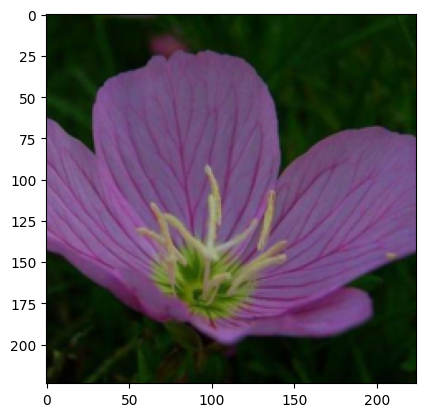

In [13]:
#img = data_dir + '/test' + '/1/' + 'image_06752.jpg'

np_image = process_image(image)
print (np_image)
imshow(np_image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [14]:

''' Predict the class (or classes) of an image using a trained deep learning model.
'''
model.class_to_idx =train_data.class_to_idx

ctx = model.class_to_idx


def predict(image_path, model, topk=5):   
    model.to('cuda:0')
    img_torch = process_image(image_path)
    img_torch = img_torch.unsqueeze_(0)
    img_torch = img_torch.float()
    
    with torch.no_grad():
        output = model.forward(img_torch.cuda())
        
    probability = F.softmax(output.data,dim=1)
    
    return probability.topk(topk)
    
    # TODO: Implement the code to predict the class from an image file
    # TODO: Implement the code to predict the class from an image file

In [15]:

#img = (data_dir + '/test' + '/13/image_05769.jpg')

val1, val2 = predict(image, model)
print(val1)
print(val2)

tensor([[0.6526, 0.1948, 0.0247, 0.0173, 0.0166]], device='cuda:0')
tensor([[97, 41, 72, 51, 74]], device='cuda:0')


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [16]:
# TODO: Display an image along with the top 5 classes
# TODO: Display an image along with the top 5 classes
def check_sanity(img):
    plt.rcParams["figure.figsize"] = (10,5)
    plt.subplot(211)
    
   
    path = img

    probabilities = predict(path, model)
    
    
    
    list_of_arrays = [t.cpu().numpy() for t in probabilities]
    list_of_arrays
    
    
    print (probabilities[1][0])
    print(np.array(list_of_arrays[1][0]))
    print (list_of_arrays[1][0])
    
    image = process_image(path)
    

    axs = imshow(image, ax = plt)
    axs.axis('off')
    axs.title(cat_to_name[str(list_of_arrays[1][0][0])])
    axs.show()
    
    a = np.array(list_of_arrays[0][0])
    print (a)
    b = [cat_to_name[str(index)] for index in np.array(list_of_arrays[1][0])]
    print (b)
    
    N=float(len(b))
    fig,ax = plt.subplots(figsize=(8,3))
    width = 0.8
    tickLocations = np.arange(N)
    ax.bar(tickLocations, a, width, linewidth=4.0, align = 'center')
    ax.set_xticks(ticks = tickLocations)
    ax.set_xticklabels(b)
    ax.set_xlim(min(tickLocations)-0.6,max(tickLocations)+0.6)
    ax.set_yticks([0.2,0.4,0.6,0.8,1,1.2])
    ax.set_ylim((0,1))
    ax.yaxis.grid(True)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.show()

tensor([98, 97, 89,  5, 74], device='cuda:0')
[98 97 89  5 74]
[98 97 89  5 74]


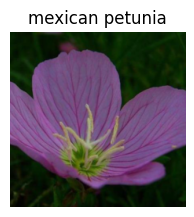

[0.2542617  0.14376892 0.08164725 0.07721876 0.07192944]
['mexican petunia', 'mallow', 'watercress', 'english marigold', 'rose']


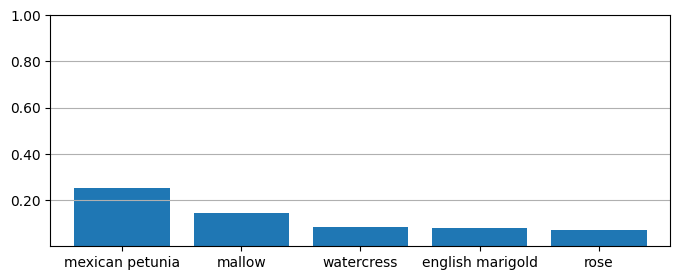

In [17]:
check_sanity(image)

## Reminder for Workspace users
If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.

In [ ]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace
#!rm checkpoint.pth